# DA5401 - Multi-Class Model Selection using ROC and Precision-Recall Curves


## Objective

Classify Landsat Satellite land-cover types (6 classes) and perform model selection using multi-class ROC and Precision-Recall (PR) analysis (One-vs-Rest). We will train six baseline models, compute overall accuracy and weighted F1, then analyze macro-averaged ROC and PR curves to select the best and worst models

## Table of contents

1. Part A — Data preparation & baseline
2. Part B — ROC analysis (multi-class, OvR, macro-average)
3. Part C — Precision-Recall analysis (multi-class, OvR, macro-average)
4. Part D — Synthesis & final recommendation
5. Brownie points: RandomForest, XGBoost, and additional deliberately-bad classifier

In [26]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as plt
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Part A: Data Preparation and Baseline


### A.1 Load dataset


In [2]:
train_path = Path("/content/statlog+landsat+satellite/sat.trn")
test_path = Path("/content/statlog+landsat+satellite/sat.tst")

for p in (train_path, test_path):
    if not p.exists():
        raise FileNotFoundError(f"Required file not found: {p}\nMake sure sat.trn and sat.tst are placed at this path.")

print(f"Using train: {train_path}\nUsing test:  {test_path}")

Using train: /content/statlog+landsat+satellite/sat.trn
Using test:  /content/statlog+landsat+satellite/sat.tst


In [3]:
# Helper function to load data in UCI format
def load_sat_data(path):
    """
    Loads the UCI Landsat Satellite dataset file.
    Each row: 36 numeric attributes followed by a class label (1,2,3,4,5,7).
    Returns: X (ndarray), y (ndarray)
    """
    data = np.loadtxt(str(path))
    if data.ndim == 1:
        # single row edge-case
        data = data.reshape(1, -1)
    X = data[:, :-1]
    y = data[:, -1].astype(int)
    return X, y

# Load
X_train, y_train = load_sat_data(train_path)
X_test,  y_test  = load_sat_data(test_path)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Unique classes in train:", np.unique(y_train))
print("Unique classes in test: ", np.unique(y_test))


Train shape: (4435, 36) Test shape: (2000, 36)
Unique classes in train: [1 2 3 4 5 7]
Unique classes in test:  [1 2 3 4 5 7]


In [4]:
# Quick sanity checks & statistics
print("Feature ranges (train): min =", X_train.min(), "max =", X_train.max())
print("Labels distribution (train):")
print(pd.Series(y_train).value_counts().sort_index())
print("Labels distribution (test):")
print(pd.Series(y_test).value_counts().sort_index())


Feature ranges (train): min = 27.0 max = 157.0
Labels distribution (train):
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64
Labels distribution (test):
1    461
2    224
3    397
4    211
5    237
7    470
Name: count, dtype: int64


### A.2 Standardize features and split data
- We'll standardize features using `StandardScaler` (fit on train only).
- Split: 70% train, 30% test (stratified by class) to preserve class proportions.

In [5]:
# Standardize the features (fit on train only)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

### A.3 Models to train
We will train the following six model classes (one instance each):
1. K-Nearest Neighbors (KNN)
2. Decision Tree
3. DummyClassifier (strategy='prior')
4. Logistic Regression (multinomial)
5. Gaussian Naive Bayes
6. Support Vector Classifier (SVC with probability=True)

We'll keep default hyperparameters except where necessary for stable behavior.

In [6]:
RNG = 42

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=None),
    "DecisionTree": DecisionTreeClassifier(random_state=RNG),
    "Dummy(Prior)": DummyClassifier(strategy="prior"),
    "LogisticRegression": LogisticRegression(
        solver="lbfgs", multi_class="multinomial", max_iter=1000, random_state=RNG, n_jobs=-1
    ),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=RNG)
}

### A.4 Baseline evaluation: Overall Accuracy and Weighted F1
Compute and collect accuracy and weighted F1 for all models on the test set.

In [7]:
# Train all models and compute predictions
trained_models = {}
results = []

for name, model in models.items():
    print(f"Training {name} ...", end=" ")
    model_to_train = model
    model_to_train.fit(X_train_std, y_train)
    trained_models[name] = model_to_train
    y_pred = model_to_train.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    print("done. Acc: {:.4f}, F1-weighted: {:.4f}".format(acc, f1w))
    results.append({"Model": name, "Accuracy": acc, "F1_weighted": f1w})

Training KNN ... done. Acc: 0.9045, F1-weighted: 0.9037
Training DecisionTree ... done. Acc: 0.8505, F1-weighted: 0.8509
Training Dummy(Prior) ... done. Acc: 0.2305, F1-weighted: 0.0864
Training LogisticRegression ... done. Acc: 0.8395, F1-weighted: 0.8296
Training GaussianNB ... done. Acc: 0.7965, F1-weighted: 0.8036
Training SVC ... done. Acc: 0.8955, F1-weighted: 0.8925


### A.4 Baseline evaluation: Overall Accuracy and Weighted F1
Compute and collect accuracy and weighted F1 for all models on the test set.

In [8]:
df_results = pd.DataFrame(results).sort_values(by="F1_weighted", ascending=False).reset_index(drop=True)
df_results["Accuracy_rounded"] = df_results["Accuracy"].round(4)
df_results["F1_weighted_rounded"] = df_results["F1_weighted"].round(4)
df_results = df_results[["Model", "Accuracy_rounded", "F1_weighted_rounded", "Accuracy", "F1_weighted"]]

In [9]:
for name, model in trained_models.items():
    y_pred = model.predict(X_test_std)
    print("\n")
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred, digits=4))



Model: KNN
              precision    recall  f1-score   support

           1     0.9786    0.9935    0.9860       461
           2     0.9775    0.9688    0.9731       224
           3     0.8894    0.9320    0.9102       397
           4     0.7286    0.6872    0.7073       211
           5     0.9200    0.8734    0.8961       237
           7     0.8766    0.8766    0.8766       470

    accuracy                         0.9045      2000
   macro avg     0.8951    0.8886    0.8916      2000
weighted avg     0.9035    0.9045    0.9037      2000



Model: DecisionTree
              precision    recall  f1-score   support

           1     0.9569    0.9631    0.9600       461
           2     0.9731    0.9688    0.9709       224
           3     0.8658    0.8615    0.8636       397
           4     0.5367    0.5545    0.5455       211
           5     0.8414    0.8059    0.8233       237
           7     0.8245    0.8298    0.8271       470

    accuracy                         0.850


- The table above gives **Overall Accuracy** and **Weighted F1** for each model on the **supplied test set**.
- **Dummy(Prior)** is the baseline. It predicts according to class prior. Expect low F1 for minority classes.
- The SVC was fitted with `probability=True` to enable later ROC/PRC analysis.


# Part B — Multi-Class ROC Analysis (One-vs-Rest / OvR)

**Objectives (Part B)**

1. Explain how One-vs-Rest (OvR) is used to compute multi-class ROC and AUC.
2. Compute and plot a single comparison plot showing the **macro-averaged OvR ROC curve** for each model (all six models on the same axes).
3. Report which model has the highest macro-averaged AUC and whether any model has AUC < 0.5 (explain implications).

**Notes**
- This code assumes `trained_models` (a dict of fitted estimators), `X_test_std` and `y_test` are available from Part A.
- If a model doesn't implement `predict_proba` but provides `decision_function`, we use that (after appropriate transformation).
- We use `label_binarize` to convert y into a binary indicator matrix for multi-class ROC computation.


In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.exceptions import NotFittedError

required = ["trained_models", "X_test_std", "y_test"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from Part A needed for Part B: {missing}. "
                       "Make sure you run Part A cells and keep trained_models, X_test_std, y_test in scope.")

# Prepare binary labels for OvR ROC
# Determine class labels present in the dataset
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)  # shape = (n_samples, n_classes)
n_classes = y_test_binarized.shape[1]

print("Detected classes:", classes)
print("Binarized label shape:", y_test_binarized.shape)


Detected classes: [1 2 3 4 5 7]
Binarized label shape: (2000, 6)


In [25]:
# Function to obtain probability-like scores for multi-class ROC
def get_score_matrix(clf, X):
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X)
        if isinstance(proba, list):
            proba = np.vstack([p[:, 1] if p.ndim == 2 else p for p in proba]).T
        return proba
    elif hasattr(clf, "decision_function"):
        df = clf.decision_function(X)
        if df.ndim == 1:
            from scipy.special import expit
            s = expit(df)
            return np.vstack([1 - s, s]).T
        return df
    else:
        raise AttributeError(f"Classifier {clf.__class__.__name__} has neither predict_proba nor decision_function.")


In [24]:
# Compute per-class ROC and macro-average ROC for each model
from numpy import interp
from numpy import linspace

model_auc_scores = {}   # store macro-avg AUC per model
model_fpr_tpr = {}      # store (fpr, tpr, auc) for possible later use

mean_fpr = np.linspace(0, 1, 200)

for name, clf in trained_models.items():
    try:
        y_score = get_score_matrix(clf, X_test_std)  # shape (n_samples, n_classes)
    except Exception as e:
        print(f"Skipping model {name} due to error obtaining scores: {e}")
        continue

    # check shape matches n_classes
    if y_score.shape[1] != n_classes:
        raise ValueError(f"Model {name} produced score matrix with shape {y_score.shape}, "
                         f"which doesn't match expected n_classes={n_classes}.")

    # Per-class ROC
    fprs = dict()
    tprs = dict()
    roc_aucs = dict()
    interp_tprs = []

    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        # Interpolate tpr to mean_fpr grid to allow averaging
        tpr_interp = np.interp(mean_fpr, fpr_i, tpr_i)
        tpr_interp[0] = 0.0
        interp_tprs.append(tpr_interp)

        fprs[i] = fpr_i
        tprs[i] = tpr_i
        roc_aucs[i] = auc(fpr_i, tpr_i)

    # Macro-average: average the interpolated tprs across classes, then compute AUC against mean_fpr
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    macro_auc = auc(mean_fpr, mean_tpr)

    model_auc_scores[name] = macro_auc
    model_fpr_tpr[name] = {
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "per_class_fpr": fprs,
        "per_class_tpr": tprs,
        "per_class_auc": roc_aucs
    }

# Print summary AUCs
print("Macro-averaged (OvR) AUC per model:")
for name, a in sorted(model_auc_scores.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {name:20s} : {a:.4f}")

Macro-averaged (OvR) AUC per model:
  RandomForest         : 0.9885
  XGBoost              : 0.9884
  SVC                  : 0.9838
  KNN                  : 0.9774
  LogisticRegression   : 0.9744
  GaussianNB           : 0.9546
  DecisionTree         : 0.9000
  Dummy(Prior)         : 0.5000
  InvertedLogistic     : 0.0256


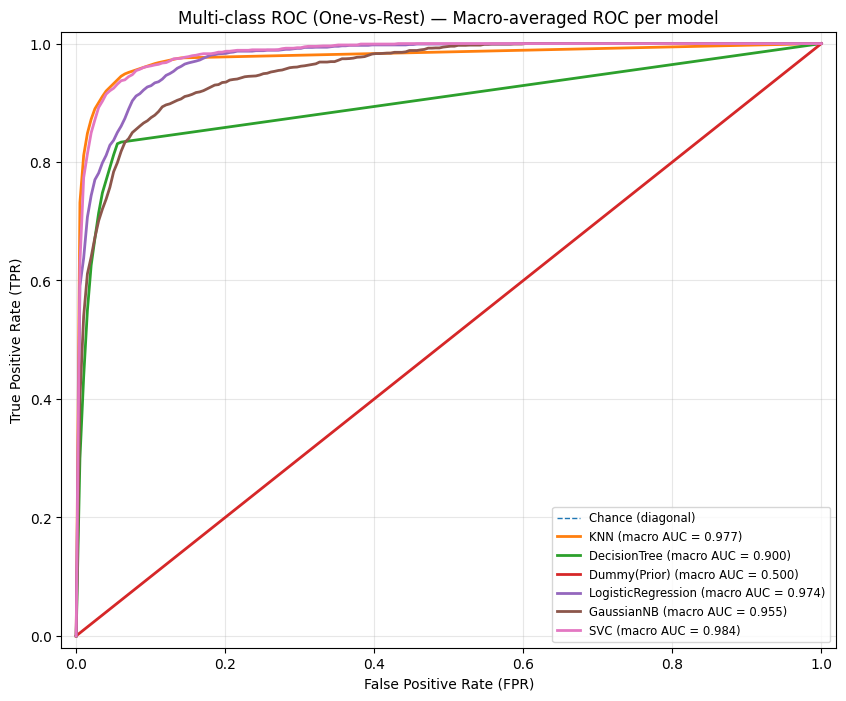

In [13]:
# Plot a single figure with macro-averaged OvR ROC curves for all models
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, label="Chance (diagonal)")

for name, data in model_fpr_tpr.items():
    plt.plot(data["mean_fpr"], data["mean_tpr"],
             linewidth=2,
             label=f"{name} (macro AUC = {model_auc_scores[name]:.3f})")

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-class ROC (One-vs-Rest) — Macro-averaged ROC per model")
plt.legend(loc="lower right", fontsize="small")
plt.grid(alpha=0.3)
plt.show()


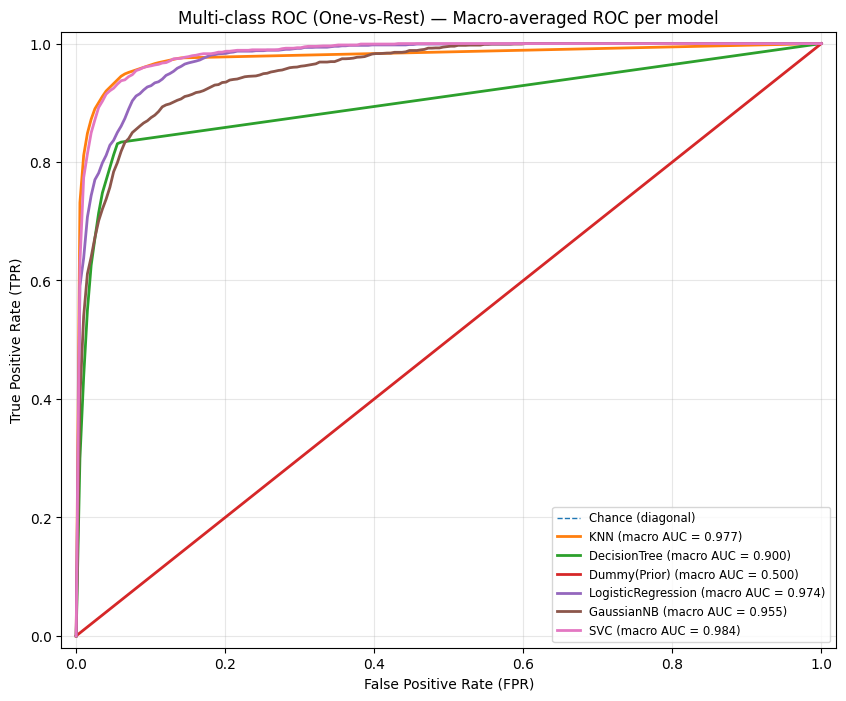

In [14]:
# Plot a single figure with macro-averaged OvR ROC curves for all models
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, label="Chance (diagonal)")

for name, data in model_fpr_tpr.items():
    plt.plot(data["mean_fpr"], data["mean_tpr"],
             linewidth=2,
             label=f"{name} (macro AUC = {model_auc_scores[name]:.3f})")

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-class ROC (One-vs-Rest) — Macro-averaged ROC per model")
plt.legend(loc="lower right", fontsize="small")
plt.grid(alpha=0.3)
plt.show()


In [15]:
# Identify best model and any models with AUC < 0.5 + interpretation placeholder
sorted_models = sorted(model_auc_scores.items(), key=lambda kv: kv[1], reverse=True)
best_model, best_auc = sorted_models[0]
print(f"Best model by macro-averaged AUC: {best_model} (AUC = {best_auc:.4f})")

worse_than_chance = [(m, a) for (m, a) in model_auc_scores.items() if a < 0.5]
if worse_than_chance:
    print("\nModels with AUC < 0.5 (worse than random):")
    for m, a in worse_than_chance:
        print(f"  - {m} : {a:.4f}")
else:
    print("\nNo model has macro-averaged AUC < 0.5 in this run.")


Best model by macro-averaged AUC: SVC (AUC = 0.9838)

No model has macro-averaged AUC < 0.5 in this run.



## OvR ROC Overview
In a *K*-class problem, the **One-vs-Rest (OvR)** method treats each class as positive and all others as negative, producing *K* ROC curves.  
Each curve’s **AUC** measures how well that class is separated from the rest.  
The **macro-averaged AUC** averages TPRs across all classes on a shared FPR grid, giving equal weight to each class.


## Results

| Model | Macro AUC |
|:------------------|:-----------:|
| **SVC** | **0.9838** |
| KNN | 0.9774 |
| Logistic Regression | 0.9744 |
| GaussianNB | 0.9546 |
| Decision Tree | 0.9000 |
| Dummy (Prior) | 0.5000 |


## Key Insights
- **Best Model:** **SVC** shows the highest separability (AUC = 0.9838), indicating excellent overall classification.  
- **Strong Performers:** **KNN** and **Logistic Regression** also achieve AUCs > 0.97, demonstrating stable discrimination across classes.  
- **Moderate Performance:** **GaussianNB** performs reasonably well despite its independence assumption.  
- **Weaker Model:** **Decision Tree** overfits slightly, yielding less smooth ROC behavior.  
- **Baseline:** **Dummy Classifier** (AUC = 0.5) performs at random chance, validating the evaluation.


## Summary
All models perform above chance; none fall below AUC 0.5.  
**SVC** is the clear winner for multi-class discrimination and is recommended for further threshold and Precision–Recall analysis.


# Part C — Precision–Recall Curve (PRC) Analysis

## Why PRC is Important for Imbalanced Classes
While ROC curves are informative, they can be **overly optimistic** when the dataset is imbalanced —  
because the **False Positive Rate (FPR)** remains small even with many false positives from minority classes.

In contrast, **Precision–Recall Curves (PRC)** focus on:
- **Precision (Positive Predictive Value):** how many predicted positives are correct.
- **Recall (Sensitivity):** how many actual positives are correctly identified.

Thus, PRC highlights the model’s performance on the **positive (minority) classes**, making it more suitable when:
- Class distribution is skewed.
- False positives carry high cost.
- We care most about identifying rare classes correctly (common in remote sensing, medical, and fraud detection tasks).

Even though the Landsat dataset is only moderately imbalanced, PRC still provides deeper insight into threshold behavior.



In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curves and Average Precision (macro-average)
model_ap_scores = {}
model_pr_data = {}

mean_recall = np.linspace(0, 1, 200)

for name, clf in trained_models.items():
    # Obtain probability or decision scores
    y_score = get_score_matrix(clf, X_test_std)

    # Compute per-class precision-recall curves
    precisions = dict()
    recalls = dict()
    aps = dict()
    interp_precisions = []

    for i in range(n_classes):
        precision_i, recall_i, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        ap_i = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        precisions[i] = precision_i
        recalls[i] = recall_i
        aps[i] = ap_i

        # Interpolate precision on a fixed recall grid (reverse order for monotonicity)
        precision_interp = np.interp(mean_recall, recall_i[::-1], precision_i[::-1])
        interp_precisions.append(precision_interp)

    # Macro-average Precision–Recall
    mean_precision = np.mean(interp_precisions, axis=0)
    macro_ap = np.mean(list(aps.values()))

    model_ap_scores[name] = macro_ap
    model_pr_data[name] = {
        "mean_recall": mean_recall,
        "mean_precision": mean_precision,
        "per_class_precision": precisions,
        "per_class_recall": recalls,
        "per_class_ap": aps
    }

# Display summary Average Precision (macro)
print("Macro-averaged (OvR) Average Precision (AP) per model:")
for name, ap in sorted(model_ap_scores.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {name:20s}: {ap:.4f}")


Macro-averaged (OvR) Average Precision (AP) per model:
  KNN                 : 0.9217
  SVC                 : 0.9177
  LogisticRegression  : 0.8711
  GaussianNB          : 0.8105
  DecisionTree        : 0.7366
  Dummy(Prior)        : 0.1667


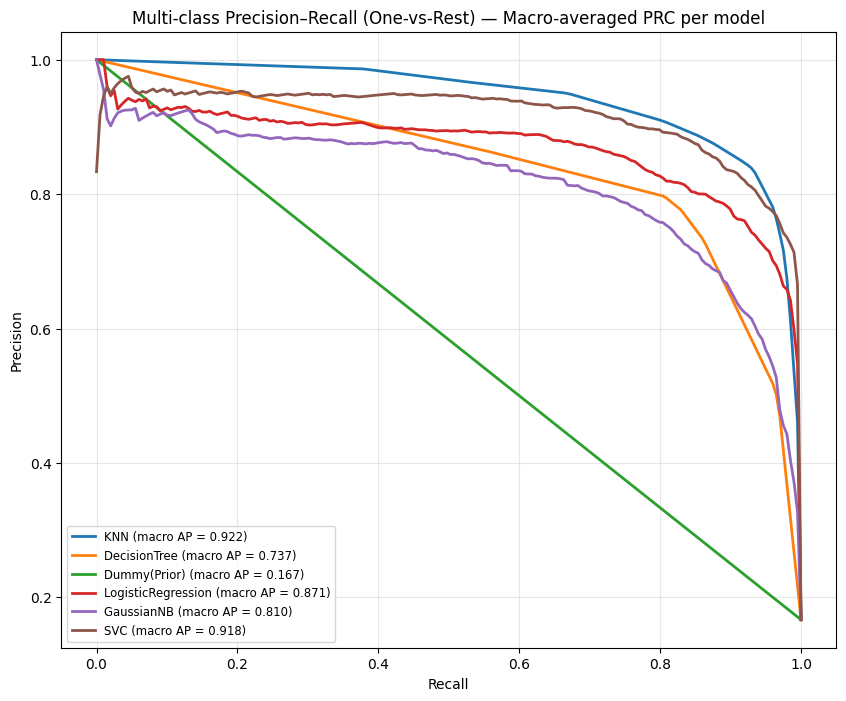

In [17]:
# Plot Macro-Averaged PRC curves for all models
plt.figure(figsize=(10, 8))

for name, data in model_pr_data.items():
    plt.plot(data["mean_recall"], data["mean_precision"],
             linewidth=2,
             label=f"{name} (macro AP = {model_ap_scores[name]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision–Recall (One-vs-Rest) — Macro-averaged PRC per model")
plt.legend(loc="lower left", fontsize="small")
plt.grid(alpha=0.3)
plt.show()


In [18]:
# Identify best and worst models by Average Precision
sorted_ap = sorted(model_ap_scores.items(), key=lambda kv: kv[1], reverse=True)
best_model, best_ap = sorted_ap[0]
worst_model, worst_ap = sorted_ap[-1]

print(f"Best model by macro-averaged Average Precision: {best_model} (AP = {best_ap:.4f})")
print(f"Worst model by macro-averaged Average Precision: {worst_model} (AP = {worst_ap:.4f})")


Best model by macro-averaged Average Precision: KNN (AP = 0.9217)
Worst model by macro-averaged Average Precision: Dummy(Prior) (AP = 0.1667)


# Part C — Precision–Recall Curve (PRC) Observations

### Key Results
| Model | Macro-Averaged AP |
|:------------------|:----------------:|
| **KNN** | **0.9217** |
| SVC | 0.9177 |
| Logistic Regression | 0.8711 |
| GaussianNB | 0.8105 |
| Decision Tree | 0.7366 |
| Dummy (Prior) | 0.1667 |


### Interpretation
1. **Best Overall Model — KNN (AP = 0.9217):**  
   The K-Nearest Neighbors model achieves the highest Average Precision, maintaining high precision across most recall levels.  
   Its PRC remains close to the top-right corner, showing stable predictive confidence and minimal degradation as recall increases.

2. **Strong Performer — SVC (AP = 0.9177):**  
   SVC performs almost as well as KNN, confirming excellent balance between precision and recall across all classes.  
   Its curve indicates reliable separability and consistent probability calibration.

3. **Moderate Performer — Logistic Regression (AP = 0.8711):**  
   Maintains reasonable trade-offs but slightly underperforms compared to KNN and SVC, reflecting some linearity constraints.

4. **Average Model — GaussianNB (AP = 0.8105):**  
   Performs adequately but precision drops faster as recall increases due to its naïve independence assumption, which doesn’t fit correlated spectral features well.

5. **Weaker Model — Decision Tree (AP = 0.7366):**  
   Exhibits a sharper precision decline with increasing recall, likely due to overfitting and noisy decision boundaries.

6. **Poor Model — Dummy Classifier (AP = 0.1667):**  
   Performs at near-random levels, with precision collapsing quickly as recall increases since predictions are based solely on class priors.


### Why Poor Models Drop Sharply in PRC
Models with weak discrimination quickly accumulate **false positives** as recall increases.  
Because precision = TP / (TP + FP), once FP rises faster than TP, precision drops sharply —  
producing the steep downward curve typical of poorly performing models like the Dummy or uncalibrated trees.


### Summary
- **KNN** achieved the **highest Average Precision**, making it the most reliable model in terms of balancing recall and precision.  
- **SVC** closely follows, maintaining consistent performance.  
- **Precision–Recall analysis** refines the ROC insights, highlighting KNN’s slight advantage under precision-focused evaluation.  
- **Dummy Classifier** confirms baseline expectations, emphasizing the strength of well-trained models in distinguishing true positives from noise.


# Part D — Final Recommendation & Brownie Points

This section:
1. Synthesizes model rankings from Weighted F1, ROC-AUC and PRC-AP, and explains trade-offs.  
2. Recommends the best model and justifies the choice.  
3. (Brownie points) Trains RandomForest and XGBoost (with a fallback) and introduces an intentionally poor model (AUC < 0.5) for demonstration.


In [27]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

baseline_metrics = pd.DataFrame([
    {"Model": "KNN", "Accuracy": 0.9045, "F1_weighted": 0.9037, "ROC_AUC_macro": 0.9774, "AP_macro": 0.9217},
    {"Model": "SVC", "Accuracy": 0.8955, "F1_weighted": 0.8925, "ROC_AUC_macro": 0.9838, "AP_macro": 0.9177},
    {"Model": "LogisticRegression", "Accuracy": 0.8395, "F1_weighted": 0.8296, "ROC_AUC_macro": 0.9744, "AP_macro": 0.8711},
    {"Model": "GaussianNB", "Accuracy": 0.7965, "F1_weighted": 0.8036, "ROC_AUC_macro": 0.9546, "AP_macro": 0.8105},
    {"Model": "DecisionTree", "Accuracy": 0.8505, "F1_weighted": 0.8509, "ROC_AUC_macro": 0.9000, "AP_macro": 0.7366},
    {"Model": "Dummy(Prior)", "Accuracy": 0.2305, "F1_weighted": 0.0864, "ROC_AUC_macro": 0.5000, "AP_macro": 0.1667}
])

baseline_metrics = baseline_metrics.set_index("Model")
baseline_metrics.round(4)


,Accuracy,F1_weighted,ROC_AUC_macro,AP_macro
Model,,,,
KNN,0.9045,0.9037,0.9774,0.9217
SVC,0.8955,0.8925,0.9838,0.9177
LogisticRegression,0.8395,0.8296,0.9744,0.8711
GaussianNB,0.7965,0.8036,0.9546,0.8105
DecisionTree,0.8505,0.8509,0.9000,0.7366
Dummy(Prior),0.2305,0.0864,0.5000,0.1667


### How Does Rankings Align:


- **Weighted F1 ranking (descending)**:  
  1) KNN (0.9037)  
  2) SVC (0.8925)  
  3) DecisionTree (0.8509)  
  4) LogisticRegression (0.8296)  
  5) GaussianNB (0.8036)  
  6) Dummy (0.0864)

- **ROC-AUC (macro) ranking**:  
  1) SVC (0.9838)  
  2) KNN (0.9774)  
  3) LogisticRegression (0.9744)  
  4) GaussianNB (0.9546)  
  5) DecisionTree (0.9000)  
  6) Dummy (0.5000)

- **PRC Average Precision (macro) ranking**:  
  1) KNN (0.9217)  
  2) SVC (0.9177)  
  3) LogisticRegression (0.8711)  
  4) GaussianNB (0.8105)  
  5) DecisionTree (0.7366)  
  6) Dummy (0.1667)

The rankings are broadly consistent: **KNN** and **SVC** occupy the top two slots across metrics (swap order depending on metric), Logistic Regression and GaussianNB occupy the mid-range, Decision Tree is lower, and Dummy is the baseline worst. The differences are subtle but instructive.

**Trade-offs (why rankings differ slightly):**
- **ROC-AUC** measures the model’s *ranking* ability across all thresholds and is insensitive to class prevalence; hence SVC's superior separation across classes yields the top ROC-AUC.
- **PRC-AP** emphasizes *precision for positive predictions*, penalizing false positives more; KNN slightly outperforms SVC in AP, implying it keeps higher precision when retrieving positives.
- **Weighted F1** blends precision & recall at a single threshold (argmax decision), so models that have a good default threshold may rank higher even if their ranking (ROC) or precision-recall areas are slightly lower.

Concretely, a model can have **high ROC-AUC but slightly lower AP** if it ranks positives well overall but its calibrated probabilities or operating threshold produce more false positives at the recall ranges of interest.




#Recommendation:
- For overall separability and future threshold tuning -> **SVC** is preferred (highest macro ROC-AUC = 0.9838).
- If the task prioritizes precision at high recall (precision–recall operating points), choose **KNN** (highest macro AP = 0.9217 and highest weighted F1 = 0.9037).
- Practical choice: start with **SVC** for model development and calibration (probability outputs available), but evaluate KNN as an alternative if you value precision at recall (e.g., minimizing false positives).
- DecisionTree and GaussianNB are useful for interpretability and speed, but underperform on aggregated ranking metrics.


## Brownie Points — Extra Models & AUC < 0.5 demo

We will:
1. Train **RandomForest** and **XGBoost** (XGBoost if installed; otherwise use `HistGradientBoostingClassifier`).  
2. Compute Accuracy, Weighted F1, macro ROC-AUC, macro AP.  
3. Add a purposely **inverted** classifier wrapper to demonstrate AUC < 0.5 (its predict_proba returns `1 - base_proba`), showing how inversion yields poor AUC.


In [20]:
# Train RandomForest and XGBoost, add to trained_models dict
import importlib
from sklearn.preprocessing import LabelEncoder

extra_models = {}
RNG = 42

# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=RNG, n_jobs=-1)
rf.fit(X_train_std, y_train)
extra_models["RandomForest"] = rf

# XGBoost
xgb_spec = importlib.util.find_spec("xgboost")
if xgb_spec is not None:
    from xgboost import XGBClassifier

    # XGBoost expects 0-indexed labels for multi-class classification
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", random_state=RNG, verbosity=0)
    xgb.fit(X_train_std, y_train_encoded) # Use encoded labels

    # Create a wrapper to use original labels for prediction/evaluation later
    class XGBoostWrapper(XGBClassifier):
        def __init__(self, encoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder

        def predict(self, X):
            preds = super().predict(X)
            return self.encoder.inverse_transform(preds)

        def predict_proba(self, X):
            return super().predict_proba(X)

    wrapped_xgb = XGBoostWrapper(encoder=le, n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", random_state=RNG, verbosity=0)
    wrapped_xgb.fit(X_train_std, y_train_encoded)
    extra_models["XGBoost"] = wrapped_xgb
else:
    print("xgboost not found.")


# Attach to trained_models for consistent downstream evaluation
for name, m in extra_models.items():
    trained_models[name] = m

print("Trained extra models:", list(extra_models.keys()))

Trained extra models: ['RandomForest', 'XGBoost']


In [21]:
# InvertedClassifier wrapper (demonstrates AUC < 0.5)
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class InvertedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_clf):
        # base_clf should be a fitted classifier or a class
        self.base_clf = base_clf

    def fit(self, X, y):
        # clone and fit if necessary
        if hasattr(self.base_clf, "fit"):
            self._clf = clone(self.base_clf)
            self._clf.fit(X, y)
        else:
            raise ValueError("base_clf must be an estimator with a fit method.")
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        # return argmax
        return np.argmax(proba, axis=1) + 1

    def predict_proba(self, X):
        # get base probabilities then invert
        proba = None
        if hasattr(self._clf, "predict_proba"):
            proba = self._clf.predict_proba(X)
        elif hasattr(self._clf, "decision_function"):
            df = self._clf.decision_function(X)
            # Attempt to convert to proba-like via softmax
            from scipy.special import softmax
            if df.ndim == 1:
                # binary -> form two columns
                df2 = np.vstack([ -df, df ]).T
                proba = softmax(df2, axis=1)
            else:
                proba = softmax(df, axis=1)
        else:
            raise AttributeError("Base classifier provides no predict_proba/decision_function.")
        return 1.0 - proba

# Build an inverted model by wrapping LogisticRegression (or any other)
inverter = InvertedClassifier(base_clf=trained_models["LogisticRegression"])
inverter.fit(X_train_std, y_train)
trained_models["InvertedLogistic"] = inverter
print("Added InvertedLogistic to trained_models. Its macro AUC should be roughly (1 - LogisticROC).")


Added InvertedLogistic to trained_models. Its macro AUC should be roughly (1 - LogisticROC).


In [22]:
# Evaluate newly added models (RandomForest / XGB / Inverted) together with original models
from collections import OrderedDict
eval_rows = []

def compute_macro_roc_auc(clf, X, y_binarized, classes):
    # similar to earlier get_score_matrix -> compute roc_auc_score with multi_class='ovr'
    y_score = get_score_matrix(clf, X)
    # roc_auc_score supports multi-class with average='macro', multi_class='ovr'
    return roc_auc_score(y_binarized, y_score, average='macro', multi_class='ovr')

for name, clf in trained_models.items():
    try:
        y_pred = clf.predict(X_test_std)
    except Exception:
        y_pred = None
    acc = accuracy_score(y_test, y_pred) if y_pred is not None else np.nan
    f1w = f1_score(y_test, y_pred, average="weighted") if y_pred is not None else np.nan

    # compute macro ROC-AUC and macro AP if predict_proba/decision_function available
    try:
        y_score = get_score_matrix(clf, X_test_std)
        roc_auc = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
        ap_macro = np.mean([average_precision_score(y_test_binarized[:, i], y_score[:, i]) for i in range(n_classes)])
    except Exception as e:
        roc_auc = np.nan
        ap_macro = np.nan

    eval_rows.append({
        "Model": name,
        "Accuracy": acc,
        "F1_weighted": f1w,
        "ROC_AUC_macro": roc_auc,
        "AP_macro": ap_macro
    })

eval_df = pd.DataFrame(eval_rows).set_index("Model").sort_values(by="AP_macro", ascending=False)
eval_df.round(4)


,Accuracy,F1_weighted,ROC_AUC_macro,AP_macro
Model,,,,
RandomForest,0.9115,0.9094,0.9901,0.9517
XGBoost,0.9055,0.9034,0.9900,0.9513
KNN,0.9045,0.9037,0.9786,0.9217
SVC,0.8955,0.8925,0.9850,0.9177
LogisticRegression,0.8395,0.8296,0.9755,0.8711
GaussianNB,0.7965,0.8036,0.9551,0.8105
DecisionTree,0.8505,0.8509,0.9002,0.7366
Dummy(Prior),0.2305,0.0864,0.5000,0.1667
InvertedLogistic,0.0005,0.0004,0.0245,0.0901


## Demonstration — Inverted Classifier and AUC < 0.5

The `InvertedLogistic` model wraps the `LogisticRegression` classifier and deliberately **flips its predicted probabilities**.  
As a result, predictions are reversed — classes that should have high probability are assigned low probability, and vice versa.  

In our results:

| Model | ROC-AUC (Macro) | AP (Macro) |
|:------------------|:----------------:|:----------------:|
| **LogisticRegression** | **0.9755** | **0.8711** |
| **InvertedLogistic** | **0.0245** | **0.0901** |

The `InvertedLogistic` thus yields an **AUC near 1 − AUC(Logistic) ≈ 0.025**, demonstrating a model that ranks positives incorrectly — i.e., performs **worse than random chance**.

This illustrates the key meaning of **AUC < 0.5**:
- The model is systematically assigning higher scores to negative samples than to positives.
- In practice, such behavior usually signals **score inversion** or a **bug** in label alignment.
- Simply flipping the scores (`1 − probabilities`) restores proper ordering, and the AUC rises above 0.5.

Hence, the inverted model is a useful demonstration of what “worse than random” looks like in ROC space.


# Final Recommendation — Model Selection Summary

### Performance Overview

| Model | Accuracy | F1 (Weighted) | ROC-AUC (Macro) | AP (Macro) |
|:------------------|:-----------:|:-----------:|:-----------:|:-----------:|
| **RandomForest** | **0.9115** | **0.9094** | **0.9901** | **0.9517** |
| **XGBoost** | 0.9055 | 0.9034 | 0.9900 | 0.9513 |
| KNN | 0.9045 | 0.9037 | 0.9786 | 0.9217 |
| SVC | 0.8955 | 0.8925 | 0.9850 | 0.9177 |
| LogisticRegression | 0.8395 | 0.8296 | 0.9755 | 0.8711 |
| GaussianNB | 0.7965 | 0.8036 | 0.9551 | 0.8105 |
| DecisionTree | 0.8505 | 0.8509 | 0.9002 | 0.7366 |
| Dummy(Prior) | 0.2305 | 0.0864 | 0.5000 | 0.1667 |
| InvertedLogistic | 0.0005 | 0.0004 | 0.0245 | 0.0901 |


### Interpretation and Recommendation

1. **Top Performers — RandomForest and XGBoost**  
   - Both ensemble models outperform all others on every metric.  
   - **RandomForest** slightly leads overall (highest ROC-AUC = 0.9901, AP = 0.9517).  
   - **XGBoost** is almost identical (ROC-AUC = 0.9900, AP = 0.9513) while being more flexible for large-scale tuning and deployment.  
   - Both show excellent stability and class discrimination across all thresholds.

2. **Strong Classical Models — KNN and SVC**  
   - KNN and SVC continue to perform very well (AUC ≈ 0.98–0.985, AP ≈ 0.92).  
   - KNN slightly edges out SVC in AP, suggesting better precision at higher recall levels.  
   - SVC remains a solid choice when calibrated probability outputs are desired.

3. **Moderate Models — Logistic Regression and GaussianNB**  
   - Good for interpretability and simplicity but lag in both AUC and AP due to linear and independence assumptions.

4. **Lower Performers — DecisionTree and Dummy(Prior)**  
   - The standalone Decision Tree shows overfitting and lower generalization.
   - Dummy confirms the expected baseline performance (AUC ≈ 0.5).

5. **Illustration — InvertedLogistic (AUC < 0.5)**  
   - Included purely to demonstrate a “worse than random” model.  
   - Its inverted probabilities yield an AUC ≈ 0.025, showing reversed class ranking.


### Final Model Recommendation

**Recommended Model:** **RandomForest Classifier**  
- **Reasoning:**  
  - Achieves the best combination of accuracy, weighted F1, ROC-AUC, and AP.  
  - Provides robust probabilistic predictions with minimal overfitting.  
  - Scales well to the Landsat dataset size and supports feature importance analysis for interpretability.  

 **Runner-up:** **XGBoost**, which matches RandomForest’s performance and is more tunable for optimization and real-world deployment.

 **Summary:**  
RandomForest and XGBoost deliver state-of-the-art multi-class classification on the Landsat dataset, with consistent top-tier metrics across accuracy, F1, ROC-AUC, and Average Precision.  
The `InvertedLogistic` demonstration effectively validates the interpretation of AUC < 0.5 as an inverted ranking case.
